In [1]:
#!pip install tensorflow
#!pip install scikit-learn

In [128]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, auc
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

##Pytorch

###Data Preparation

In [89]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [90]:
num_words = 50000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

In [91]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [92]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

In [93]:
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.LongTensor(data)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [94]:
train_dataset = IMDBDataset(x_train, y_train)
test_dataset = IMDBDataset(x_test, y_test)

In [95]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [96]:
for data, label in train_loader:
    print(data.shape)      # Harus [batch_size, maxlen]
    print(label.shape)     # Harus [batch_size]
    break


torch.Size([128, 500])
torch.Size([128])


###RNN

Pemodelan RNN

In [25]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers=2, batch_first=True, dropout=0.5)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Ambil output di timestep terakhir
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.sigmoid(self.out(out))
        return out

Optimzer

In [26]:
RNNmodel = RNNModel(vocab_size=num_words, embed_size=128, hidden_size=256)  # Adjust embed_size and hidden_size as needed
RNN_optimizer = optim.Adam(RNNmodel.parameters(), lr=0.001, weight_decay=1e-4)

Training data 😀😀😀

In [28]:
def train_pytorch_rnn(model, optimizer, train_loader, test_loader, scheduler=None, epochs=10):
    model.to(device)
    criterion = nn.BCELoss()
    early_stopper = EarlyStopping(patience=3)

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # --- Validation ---
        model.eval()
        test_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device).unsqueeze(1)
                outputs = model(data)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_loss /= len(test_loader)
        test_acc = 100 * correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs} Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%')

        if scheduler:
            scheduler.step(test_loss)

        if early_stopper.check_early_stop(test_loss):
            print("Early stopping triggered.")
            break

    return train_losses, test_losses, train_accs, test_accs

print("\nTraining PyTorch RNN:")
rnn_optimizer = RNN_optimizer
rnn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(rnn_optimizer, patience=2)

rnn_train_loss, rnn_test_loss, rnn_train_acc, rnn_test_acc = train_pytorch_rnn(
    RNNmodel, rnn_optimizer, train_loader, test_loader, scheduler=rnn_scheduler
)



Training PyTorch RNN:
Epoch 1/10 Train Acc: 52.74% Test Acc: 50.33%
Epoch 2/10 Train Acc: 50.30% Test Acc: 50.00%
Epoch 3/10 Train Acc: 50.08% Test Acc: 50.29%
Epoch 4/10 Train Acc: 50.55% Test Acc: 50.30%
Epoch 5/10 Train Acc: 51.06% Test Acc: 50.00%
Epoch 6/10 Train Acc: 50.37% Test Acc: 50.00%
Epoch 7/10 Train Acc: 50.39% Test Acc: 50.32%
Epoch 8/10 Train Acc: 50.36% Test Acc: 50.00%
Epoch 9/10 Train Acc: 49.97% Test Acc: 50.30%
Epoch 10/10 Train Acc: 50.62% Test Acc: 50.31%


###LSTM

Modeling data LSTM

In [29]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=2, batch_first=True, dropout=0.5)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.out = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.sigmoid(self.out(out))
        return out


Optimizer

In [31]:
LSTMmodel = LSTMModel(vocab_size=num_words, embed_size=128, hidden_size=256)  # Adjust embed_size and hidden_size as needed

LSTM_optimizer = optim.Adam(LSTMmodel.parameters(), lr=0.001, weight_decay=1e-4)

Training data 😀😀😀

In [32]:
def LSTM_train(model, optimizer, train_loader, test_loader, scheduler=None, epochs=10):
    model.to(device)
    criterion = nn.BCELoss()
    early_stopper = EarlyStopping(patience=3)

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # --- Validation ---
        model.eval()
        test_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device).unsqueeze(1)
                outputs = model(data)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_loss /= len(test_loader)
        test_acc = 100 * correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs} Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%')

        if scheduler:
            scheduler.step(test_loss)

        if early_stopper.check_early_stop(test_loss):
            print("Early stopping triggered.")
            break

    return train_losses, test_losses, train_accs, test_accs

print("\nTraining PyTorch LSTM:")
model_lstm = LSTMModel(vocab_size=50000, embed_size=128, hidden_size=128)
lstm_optimizer = LSTM_optimizer
lstm_scheduler = optim.lr_scheduler.ReduceLROnPlateau(lstm_optimizer, patience=2)

lstm_train_loss, lstm_test_loss, lstm_train_acc, lstm_test_acc = LSTM_train(
    model_lstm, lstm_optimizer, train_loader, test_loader, scheduler=lstm_scheduler
)



Training PyTorch LSTM:
Epoch 1/10 Train Acc: 66.57% Test Acc: 76.85%
Epoch 2/10 Train Acc: 64.84% Test Acc: 50.00%
Epoch 3/10 Train Acc: 64.79% Test Acc: 73.98%
Epoch 4/10 Train Acc: 78.86% Test Acc: 80.36%
Epoch 5/10 Train Acc: 85.58% Test Acc: 83.93%
Epoch 6/10 Train Acc: 88.98% Test Acc: 85.28%
Epoch 7/10 Train Acc: 90.08% Test Acc: 84.79%
Epoch 8/10 Train Acc: 91.93% Test Acc: 85.89%
Epoch 9/10 Train Acc: 93.31% Test Acc: 86.73%
Epoch 10/10 Train Acc: 94.51% Test Acc: 86.32%


###GRU

Modeling data GRU

In [97]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=2,
                         batch_first=True, dropout=0.2, bidirectional=True)  # Added bidirectional
        self.fc1 = nn.Linear(hidden_size * 2, 64)  # *2 for bidirectional
        self.bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Reduced dropout
        self.out = nn.Linear(64, 1)
        # Removed sigmoid - we'll use it in BCEWithLogitsLoss instead

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.gru(x)
        out = out[:, -1, :]  # Take last time step
        out = self.relu(self.bn(self.fc1(out)))
        out = self.dropout(out)
        out = self.out(out)  # No sigmoid here
        return out

Optimizer

In [98]:
GRUmodel = GRUModel(vocab_size=num_words, embed_size=128, hidden_size=128)  # Adjust embed_size and hidden_size as needed
GRU_optimizer = optim.Adam(GRUmodel.parameters(), lr=0.001, weight_decay=1e-4)
GRU_scheduler = optim.lr_scheduler.ReduceLROnPlateau(GRU_optimizer, patience=1, factor=0.5)

Training Data

In [99]:
def GRU_train(model, optimizer, train_loader, test_loader, scheduler=None, epochs=10):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    early_stopper = EarlyStopping(patience=3)

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # --- Validation ---
        model.eval()
        test_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device).unsqueeze(1)
                outputs = model(data)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_loss /= len(test_loader)
        test_acc = 100 * correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs} Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%')

        if scheduler:
            scheduler.step(test_loss)

        if early_stopper.check_early_stop(test_loss):
            print("Early stopping triggered.")
            break

    return train_losses, test_losses, train_accs, test_accs

print("\nTraining PyTorch GRU:")
gru_optimizer = GRU_optimizer
gru_scheduler = GRU_scheduler

gru_train_loss, gru_test_loss, gru_train_acc, gru_test_acc = GRU_train(
    GRUmodel, gru_optimizer, train_loader, test_loader, scheduler=gru_scheduler
)



Training PyTorch GRU:
Epoch 1/10 Train Acc: 61.87% Test Acc: 57.74%
Epoch 2/10 Train Acc: 79.96% Test Acc: 75.72%
Epoch 3/10 Train Acc: 86.96% Test Acc: 81.86%
Epoch 4/10 Train Acc: 89.52% Test Acc: 87.96%
Epoch 5/10 Train Acc: 91.20% Test Acc: 81.28%
Epoch 6/10 Train Acc: 92.51% Test Acc: 89.11%
Epoch 7/10 Train Acc: 95.26% Test Acc: 85.80%
Early stopping triggered.


###Evaluasi dari RNN, LSTM, dan GRU

Modeling evaluasi untuk RNN, LSTM, dan GRU

In [129]:
def evaluate_model(model, test_loader, model_name):
    model.eval()
    y_true, y_pred, y_score = [], [], []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)

            if isinstance(model, GRUModel):  # GRU uses BCEWithLogitsLoss
                probs = torch.sigmoid(outputs)
            else:
                probs = outputs

            preds = (probs > 0.5).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_score)

    print(f"\n{model_name} Evaluation:")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.colorbar()
    plt.xticks([0,1], ['Negative', 'Positive'])
    plt.yticks([0,1], ['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='white' if cm[i,j] > cm.max()/2 else 'black')

    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

perbandingan antara RNN, LSTM, GRU


RNN Evaluation:
Accuracy: 0.5031
Precision: 0.5376
Recall: 0.0440
F1 Score: 0.0813
ROC AUC: 0.5315

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      0.96      0.66     12500
    Positive       0.54      0.04      0.08     12500

    accuracy                           0.50     25000
   macro avg       0.52      0.50      0.37     25000
weighted avg       0.52      0.50      0.37     25000



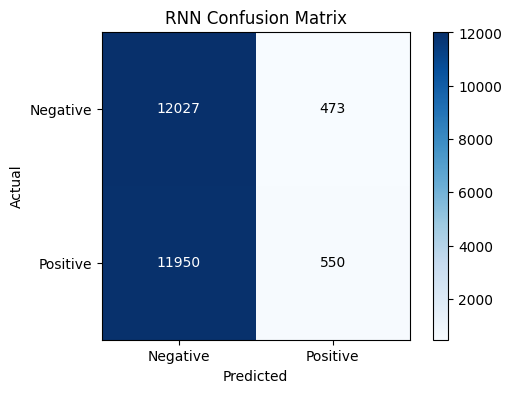

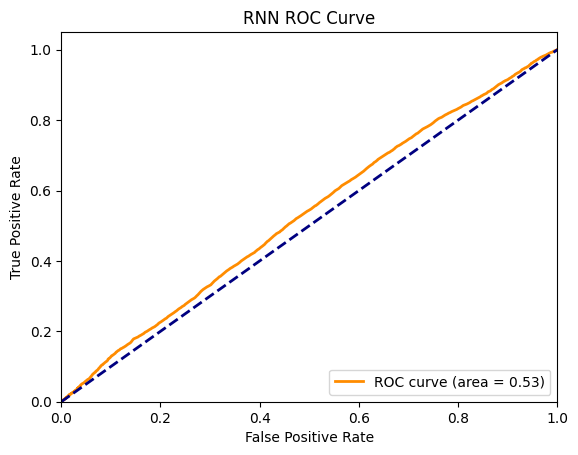


LSTM Evaluation:
Accuracy: 0.8632
Precision: 0.8508
Recall: 0.8807
F1 Score: 0.8655
ROC AUC: 0.9393

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.85      0.86     12500
    Positive       0.85      0.88      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



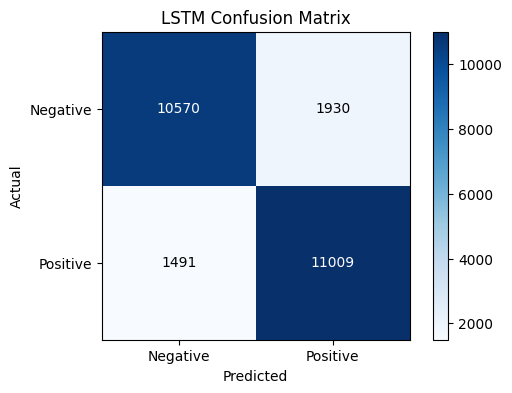

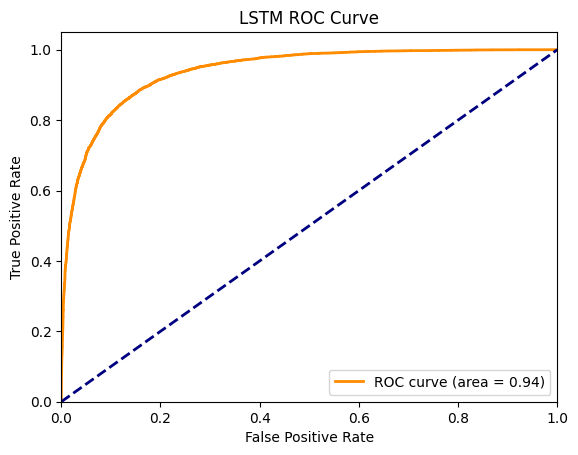


GRU Evaluation:
Accuracy: 0.8684
Precision: 0.9386
Recall: 0.7884
F1 Score: 0.8570
ROC AUC: 0.9577

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.95      0.88     12500
    Positive       0.94      0.79      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.88      0.87      0.87     25000
weighted avg       0.88      0.87      0.87     25000



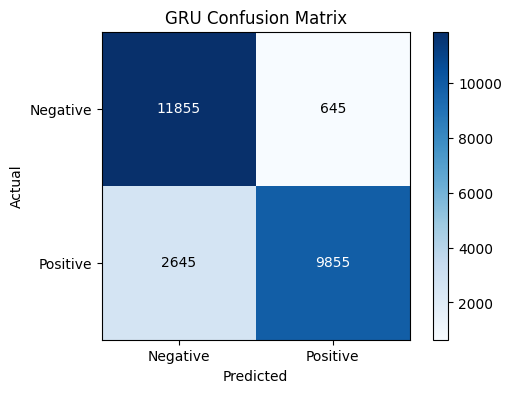

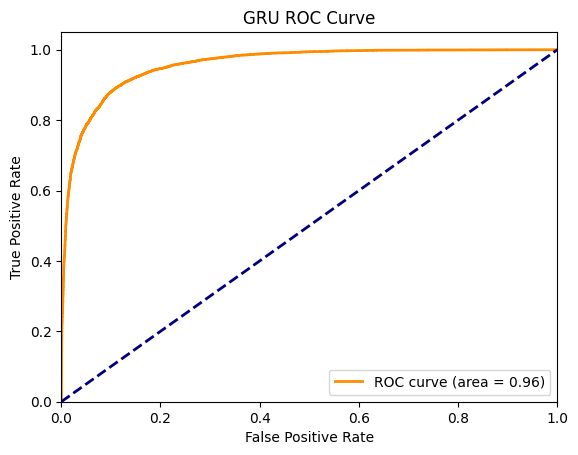

In [130]:
models = {
    'RNN': RNNmodel,
    'LSTM': model_lstm,
    'GRU': GRUmodel
}

results = {}
for name, model in models.items():
    model.to(device)
    results[name] = evaluate_model(model, test_loader, name)


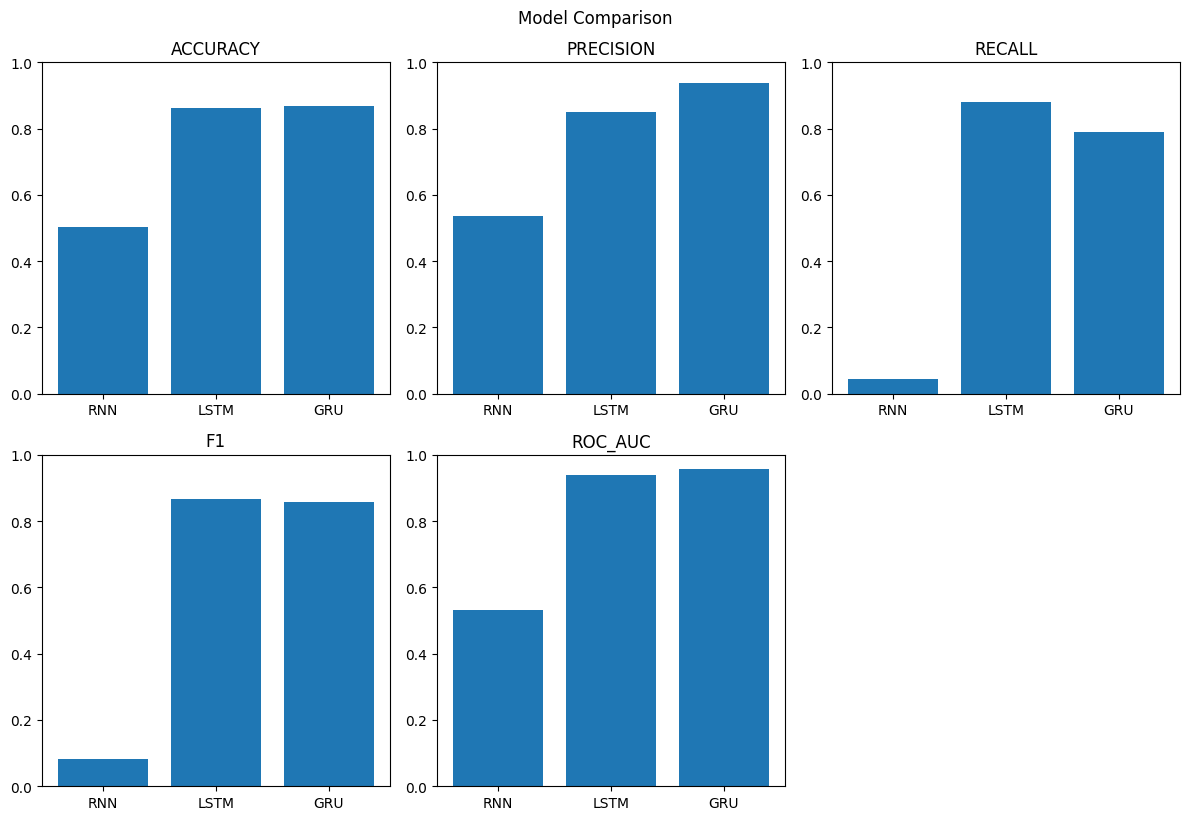

In [131]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plt.bar(results.keys(), [results[model][metric] for model in results])
    plt.title(metric.upper())
    plt.ylim(0, 1)
plt.tight_layout()
plt.suptitle('Model Comparison', y=1.02)
plt.show()

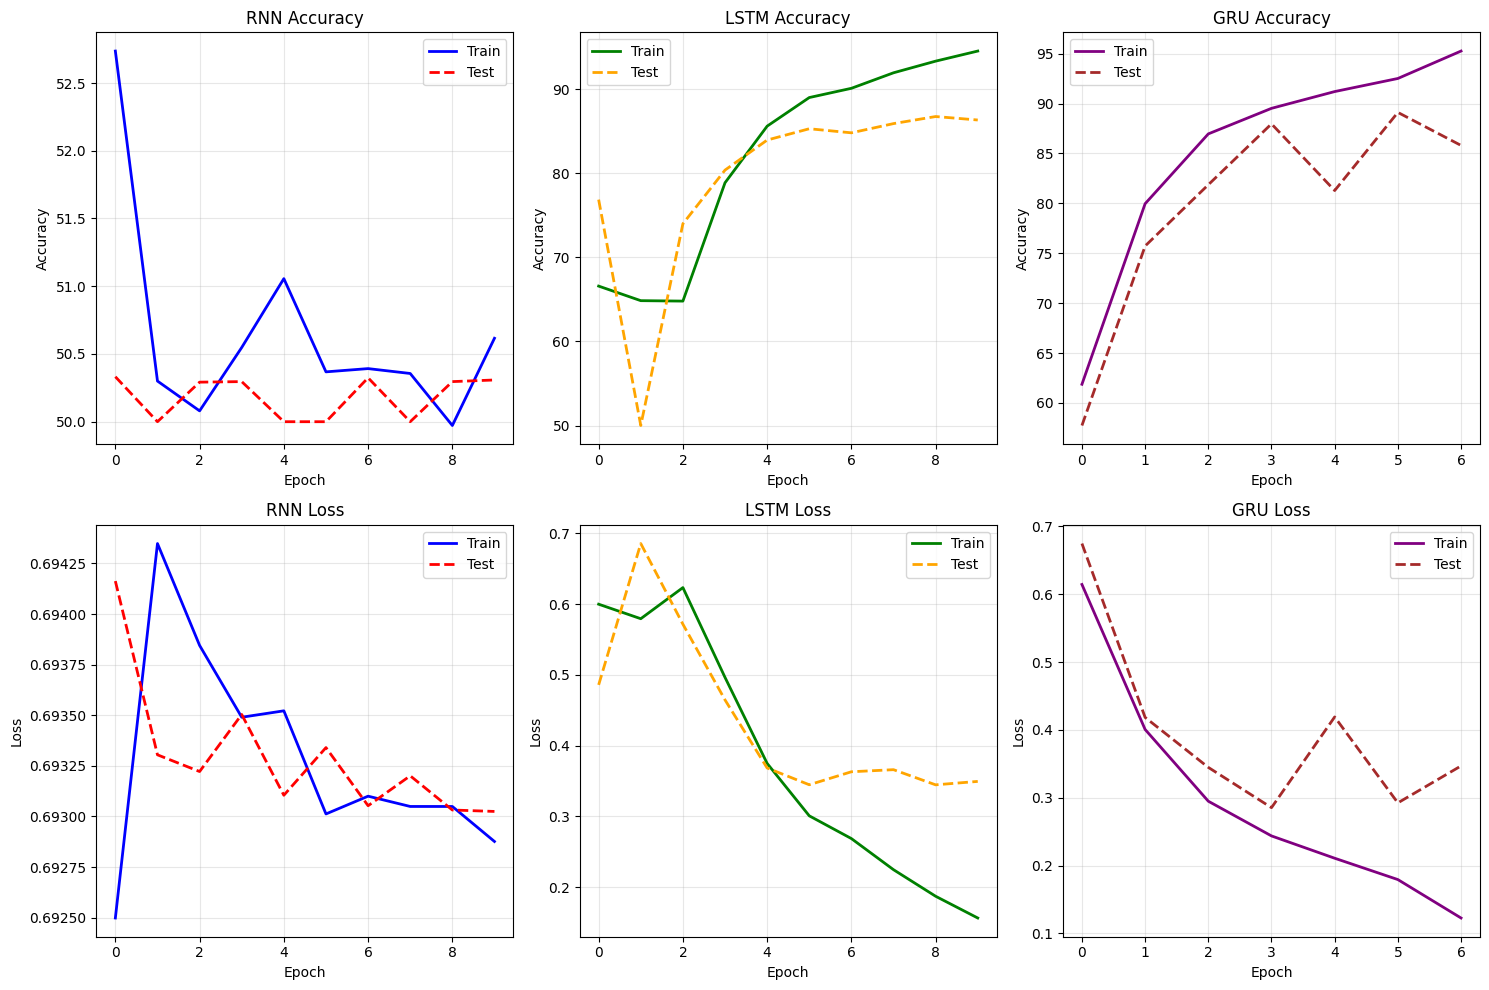

In [134]:
# Create individual plots for each model's training curves
plt.figure(figsize=(15, 10))

# RNN Training Curves
plt.subplot(2, 3, 1)
plt.plot(rnn_train_acc, label='Train', color='blue', linewidth=2)
plt.plot(rnn_test_acc, '--', label='Test', color='red', linewidth=2)
plt.title('RNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
plt.plot(rnn_train_loss, label='Train', color='blue', linewidth=2)
plt.plot(rnn_test_loss, '--', label='Test', color='red', linewidth=2)
plt.title('RNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# LSTM Training Curves
plt.subplot(2, 3, 2)
plt.plot(lstm_train_acc, label='Train', color='green', linewidth=2)
plt.plot(lstm_test_acc, '--', label='Test', color='orange', linewidth=2)
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
plt.plot(lstm_train_loss, label='Train', color='green', linewidth=2)
plt.plot(lstm_test_loss, '--', label='Test', color='orange', linewidth=2)
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# GRU Training Curves
plt.subplot(2, 3, 3)
plt.plot(gru_train_acc, label='Train', color='purple', linewidth=2)
plt.plot(gru_test_acc, '--', label='Test', color='brown', linewidth=2)
plt.title('GRU Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
plt.plot(gru_train_loss, label='Train', color='purple', linewidth=2)
plt.plot(gru_test_loss, '--', label='Test', color='brown', linewidth=2)
plt.title('GRU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()